# 1편. 서울시내 따릉이 대여소 살펴보기.

## 데이터 로드

In [1]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import missingno as mnso

import warnings
warnings.filterwarnings('ignore')

geo_path = 'data/seoul_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumGothic'

In [2]:
rental = pd.read_csv('data/서울특별시 공공자전거 대여소 정보.csv')
rental.head()

,구명,대여소ID,대여소번호,대여소명,대여소 주소,거치대수,위도,경도
0,강남구,ST-777,2301,현대고등학교 건너편,서울특별시 강남구 압구정로 134현대고등학교 건너편,10,37.524071,127.021790
1,강남구,ST-787,2302,교보타워 버스정류장(신논현역 3번출구 후면),서울특별시 강남구 봉은사로 지하 102교보타워 버스정류장,10,37.505581,127.024277
2,강남구,ST-788,2303,논현역 7번출구,서울특별시 강남구 학동로 지하 102논현역 7번출구,15,37.511517,127.021477
3,강남구,ST-789,2304,신영 ROYAL PALACE 앞,서울특별시 강남구 언주로 626신영 ROYAL PALACE앞,10,37.512527,127.035835
4,강남구,ST-790,2305,MCM 본사 직영점 앞,서울특별시 강남구 언주로 734MCM 본사 직영점 앞,10,37.520641,127.034508


In [3]:
rental.shape

(1460, 8)

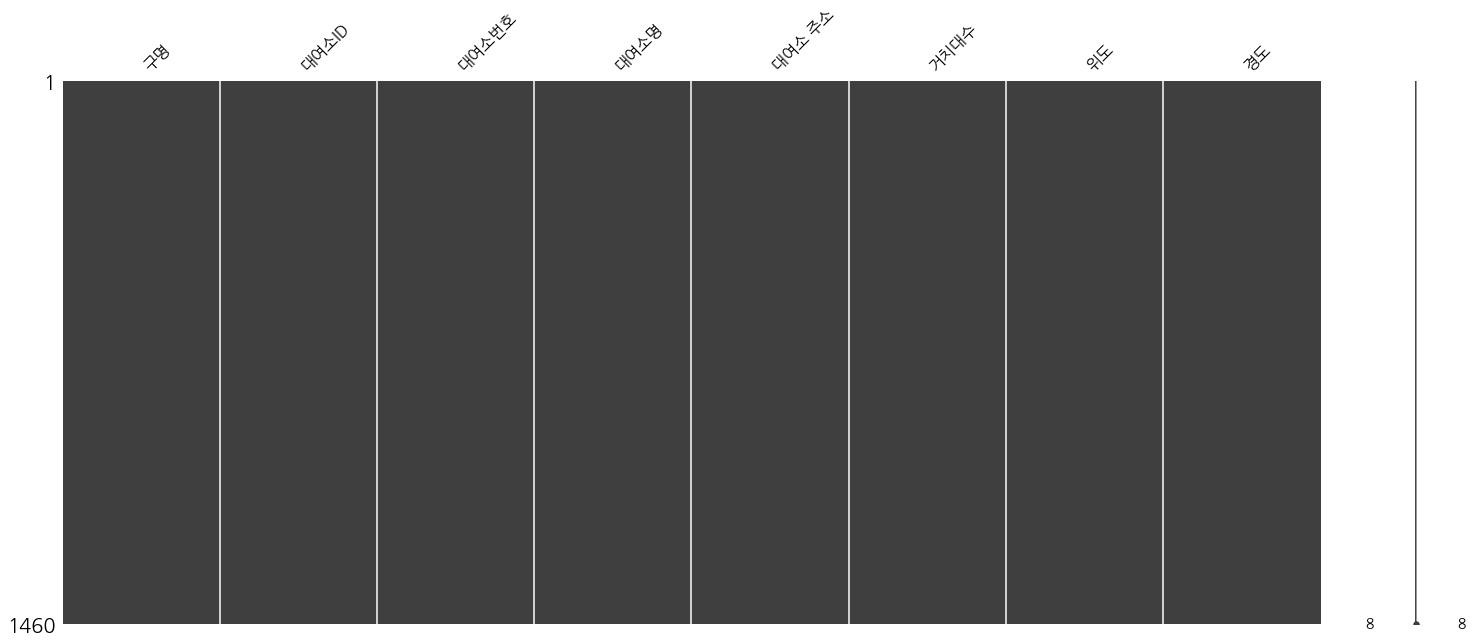

In [4]:
import missingno as msno

msno.matrix(rental)

## 1. 따릉이 대여소 위치 무작정 시각화 해보기

In [5]:
bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=10.8, tiles='CartoDB positron')
for i, row in rental.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=1,
        fill=True,
    ).add_to(bike_map)
bike_map

곳곳에 설치된 따릉이 대여소들  
뭐.. 여기저기 많은 것 같다.  
  
히트맵으로 대여소들의 밀집도를 살펴보면, 

In [6]:
bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=10.8, tiles='CartoDB positron')
plugins.HeatMap(rental[['위도', '경도']].values.tolist(),
                        radius=10, blur=5
                        ).add_to(bike_map)
plugins.Fullscreen(positions='topright').add_to(bike_map)
bike_map

역시 아무래도 **서울 한 가운데 지점이 눈에 띄게 밀집도가 높은 것**을 알 수 있다.

## 2. 지역구 중심으로 살펴보기

### 2.1. 대여소 개수 살펴보기

In [21]:
bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=11, tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str,
                  data=have_bikes,
                  key_on='feature.properties.SIG_KOR_NM', 
                  fill_color='Blues').add_to(bike_map)
bike_map

지역별 대여소 개수. 색이 진할수록 해당 지역에 대여소 개수가 많다는 뜻이다.  
**강남 3구(서초, 송파, 강남) 와, 한강 서쪽 지역(마포, 강서, 영등포)** 이 대여소가 많은 것을 한 눈에 알 수 있다.

조금 더 수치적으로 확인해보면,

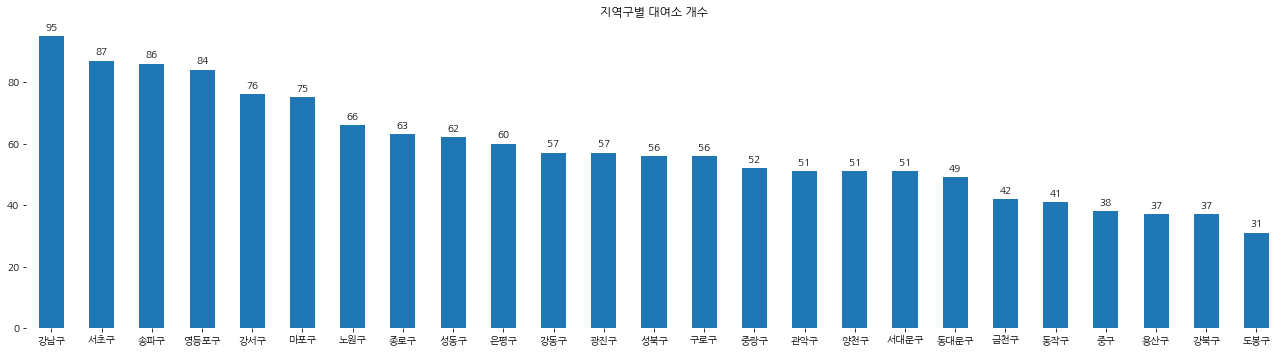

In [7]:
have_bikes = rental.groupby('구명').size()
have_bikes.sort_values(ascending=False, inplace=True)

ax = have_bikes.plot(kind='bar', figsize=(18, 5), rot=0, title="지역구별 대여소 개수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(False)
plt.xlabel('')
plt.tight_layout()
plt.show()

가장 많은 곳(강남구, 95개) 과 가장 적은 곳(도봉구, 31개)의 차이가 약 **3배 가량** 나는 것을 알 수 있다.

### 2.2. 지역별 대여소당 평균 거치대수 비교

하나의 따릉이 대여소에는 따릉이를 거치해놓을 수 있는 여러 개의 거치대가 있는데, 이 거치대 수에 대해서도 한번 살펴보자.  
먼저, 서울 시내 전체에서, 거치대 수의 분포는 어떨까?

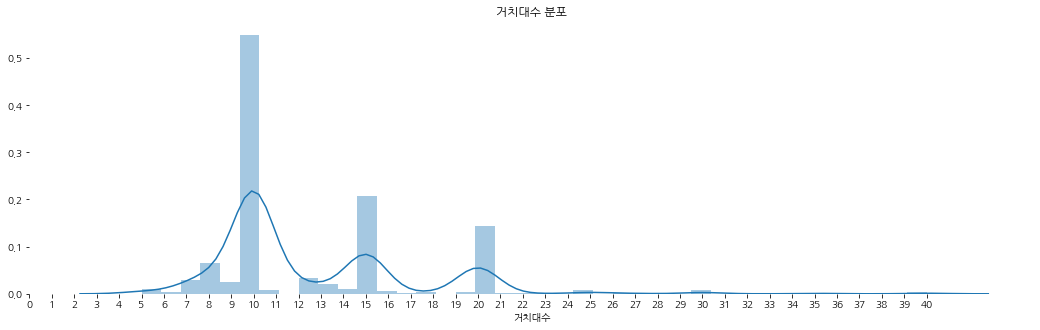

In [9]:
plt.figure(figsize=(18, 5))
sns.distplot(rental['거치대수'])
plt.title("거치대수 분포")
plt.xticks(range(0, 41))
plt.box(False)
plt.show()

일반적으로 **10개, 조금 더 많은 곳은 15개, 20개**가 대표적이다.  
간혹가다, 30개, 40개인 곳도 보이는데, 이런 곳은 아무래도 대형 대여소인듯 하다.

이제 다시, 지역별로 대여소당 평균 거치대 수를 살펴보면,

In [22]:
bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=10.8, tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str,
                  data=bike_rental,
                  key_on='feature.properties.SIG_KOR_NM', 
                  fill_color='Blues').add_to(bike_map)
bike_map

지역별 대여소의 평균 거치대수 개수. 색이 진할수록 값이 크다.  
마포, 영등포, 서초의 경우, 대여소 수도 많았지만, 평균 거치대수도 많다. 즉 따릉이가 제일 많이 비치되어있는 지역들이다.  
용산의 경우, 대여소 수는 적었지만, 평균 거치대수는 많다. 즉, 한 대여소에 한 번에 많은 따릉이가 비치되어있다.  

좀 더 자세히 보기 위해, 수치값을 보면

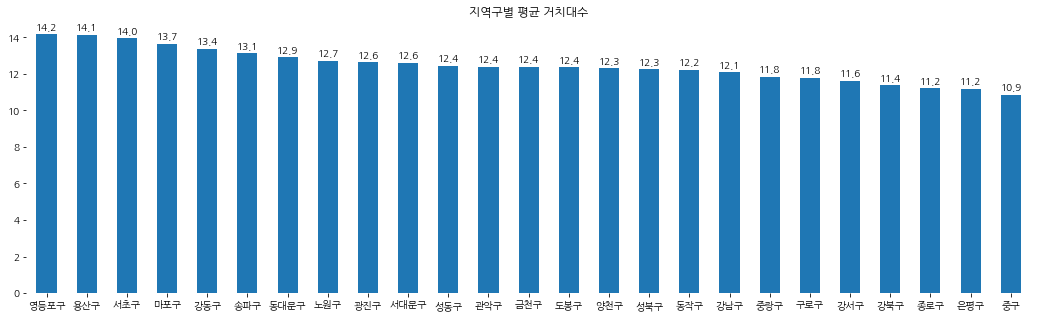

In [10]:
bike_rental = rental.groupby('구명')['거치대수'].sum()
bike_rental = bike_rental / have_bikes
bike_rental.sort_values(ascending=False, inplace=True)

ax = bike_rental.plot(kind='bar', figsize=(18, 5), rot=0, title="지역구별 평균 거치대수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%.1f"%(height), (left+width/2, height+0.3), ha='center')
plt.box(False)
plt.xlabel("")
plt.show()

지역별 평균 거치대수는 10~15대 사이로, 엄청 큰 차이를 보이지는 않는다.

### 2.3. 가장 가까운 대여소간 평균 거리는 얼마나 다를까?

하나의 대여소와 가장 가까운 대여소의 거리들의 평균을 구해보자.  
즉, 대여소가 모여있다면, 평균 거리는 작을 것이고, 흩어져있다면, 평균 거리는 클 것이다.  

먼저, 각 지역별로, 가장 가까운 대여소간 거리의 분포를 살펴보면.

In [24]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    m = 1000 * km
    return m

In [25]:
dict_dists = {}
for name, df in rental.groupby('구명'):
    dists = []
    for i, i_row in df.iterrows():
        min_dist = float('INF')
        
        for j, j_row in df.iterrows():
            if i == j:
                continue
            distance = haversine(i_row['경도'], i_row['위도'], j_row['경도'], j_row['위도'])       
            min_dist = distance if distance < min_dist else min_dist
                
        dists.append(min_dist)
    dict_dists[name] = dists

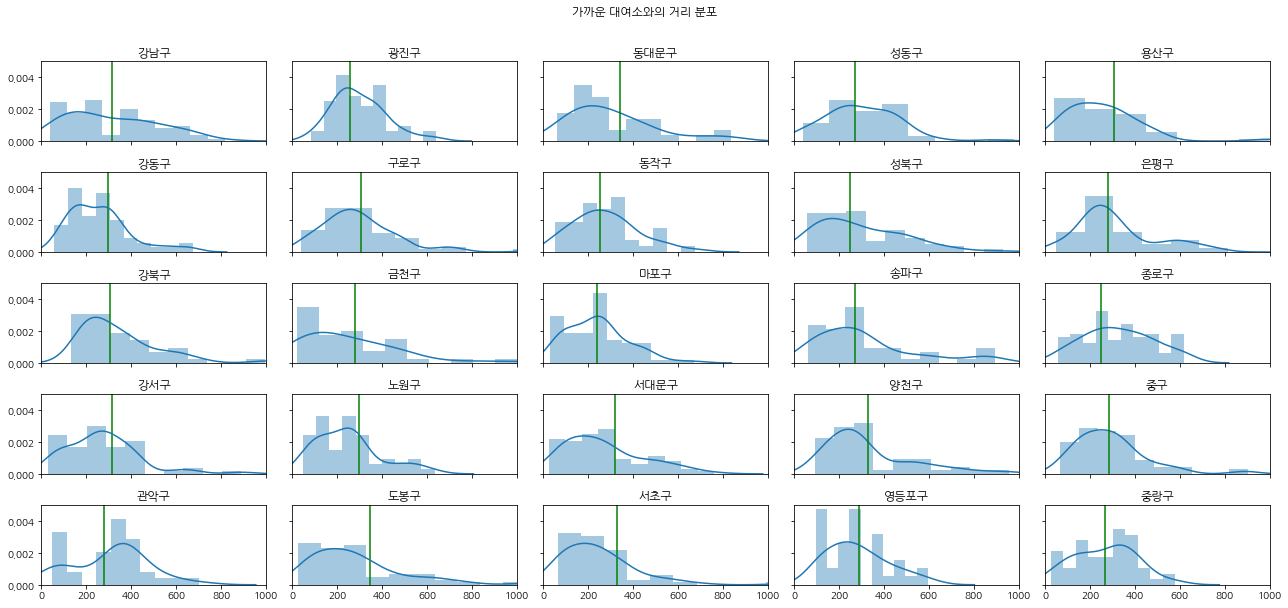

In [14]:
fig, axes = plt.subplots(5, 5, figsize=(18, 8), sharex=True, sharey=True)

i, j = 0, 0
for name, dists in dict_dists.items():
    sns.distplot(dists, ax=axes[i][j], bins=10)
    axes[j][i].set_title(name)
    axes[j][i].axvline(np.array(dists).mean(), color='green')
    j += 1
    if j >= 5:
        i += 1
        j = 0

fig.suptitle("가까운 대여소와의 거리 분포", y=1.05)
plt.xlim(0, 1000)
fig.tight_layout()
plt.show()

초록색 선은 해당 지역의 평균 값(평균 거리) 이다.  
가장 가까운 대여소간의 거리는 대부분 **200~400m** 안이다.  
관악구의 경우, 봉우리가 2개 있는 분포가 눈에 띈다. 밀집된 대여소가 두 군데로 보여진다. 이는 직접 확인해봐야겠다.  

잠깐 관악구의 대여소 분포를 지도에서 살펴보면,

In [16]:
Gwanak = rental[rental['구명'] == '관악구']

bike_map = folium.Map(location=[Gwanak['위도'].mean(), Gwanak['경도'].mean()], zoom_start=14)
for i, row in Gwanak.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=5,
        fill=True,
    ).add_to(bike_map)
bike_map

plugins.HeatMap(Gwanak[['위도', '경도']].values.tolist()).add_to(bike_map)
bike_map

예상했던 대로, 신림역과 서울대입구역 근방으로 대여소들이 밀집되어 있음을 확인할 수 있다.

다시 돌아가, 지역별로 가까운 대여소 평균 거리를 살펴보자.  
이번에는 수치값도 나름 중요하므로, 시각화된 지도와 막대 그래프를 같이본 뒤 해석해보자.

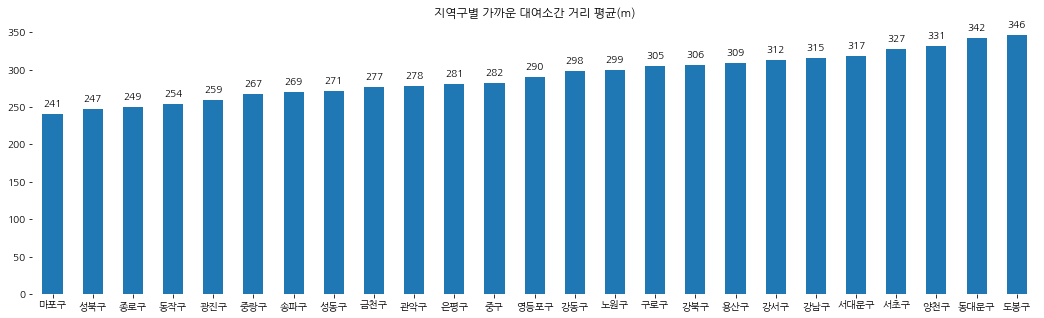

In [17]:
dist_means = {name: np.mean(dists) for name, dists in dict_dists.items() }
dist_means = pd.Series(dist_means)
dist_means.sort_values(inplace=True)

ax = dist_means.plot(kind='bar', figsize=(18, 5), rot=0, legend=False, title="지역구별 가까운 대여소간 거리 평균(m)")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+10), ha='center')
plt.box(False)
plt.show()

In [18]:
bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=10.8, tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str,
                  data=dist_means,
                  key_on='feature.properties.SIG_KOR_NM', 
                  fill_color='Blues').add_to(bike_map)
bike_map

지역별 대여소간 평균거리는 240~350m 안쪽이다.  
대여소, 거치대수가 많던 마포구가, 이번에도, 대여소간 평균 거리가 제일 작았다. 이쯤 되면, 마포에 좀 주목할 필요가 있어보인다.    
서울 한가운데에 있는 종로와 성북이 그 다음으로 작았다. 대여소가 밀집되어있는 대표적인 지역들이다.  
강남 3구 중, 유독 송파만 거리가 짧았다. 이후에, 좀 더 구체적으로 살펴볼만할 듯 하다.  
도봉, 동대문, 양천은 평균거리가 유독 컸다. 이유가 뭘까? 이 역시 이후에 좀 더 구체적으로 살펴봐야겠다.  

## 정리 

- 서울에 전반적으로 대여소가 잘 설치되어있다. 그 중, 특히 **서울 가운데 지역에 조금 더 밀집**이 되어있다.
- 대여소의 개수는 **강남3구와 강서지역(강서, 마포, 영등포)**에 유독 많았고, 제일 적은 지역과 가장 많은 지역의 차이는 **3배**정도 난다.
- 한 대여소당 평균 거치대 수는 **10~15개**로, 영등포와 용산, 서초가 가장 많았다.
- 지역별 대여소간 가장 가까운 평균거리는 **240~350m로, 마포구(241m)가 제일 작았다.** 제일 작은 지역과 큰 지역간의 차이는 100m 가량 난다.

## 데이터 출처

데이터는 2018.11.29일자, 서울특별시 공공자전거 대여소 정보를 사용했다.